# Plot global/regional histogram of MCS count

* Only loads one year, 2020.
* Uses a 4x4 degree lat/lon grid to calculate histogram.
* Counts each separate time once per bin - different from Feng et al. 2021 supplement Fig. S7 which only counts once per MCS in each 2D bin.
* Can also plot regional histograms.

In [1]:
from pathlib import Path

import cartopy
import dask
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import xarray as xr

%matplotlib inline

In [2]:
statsdir = Path('/gws/nopw/j04/mcs_prime/mmuetz/data/MCS_Global/stats')
stats_paths = sorted(statsdir.glob('mcs_tracks_final_extc_????????.0000_????????.0000.nc'))
print(stats_paths[0])
print(stats_paths[-1])

/gws/nopw/j04/mcs_prime/mmuetz/data/MCS_Global/stats/mcs_tracks_final_extc_20000601.0000_20010101.0000.nc
/gws/nopw/j04/mcs_prime/mmuetz/data/MCS_Global/stats/mcs_tracks_final_extc_20200101.0000_20210101.0000.nc


In [3]:
# Only do for one year.
dstracks = xr.open_dataset(stats_paths[-1])

dstracks.meanlon.load()
dstracks.meanlat.load();

In [4]:
def plot_heatmap(
    dstracks,
    xmin=-180,
    xmax=180,
    ymin=-60,
    ymax=60,
    # 4 degrees of lon/lat.
    dx=4,
    dy=4,
):
    nan_mask = ~np.isnan(dstracks.meanlon.values)
    meanlon = dstracks.meanlon.values[nan_mask]
    meanlat = dstracks.meanlat.values[nan_mask]
    # Calculate 2D histogram, based on dx==dy==4 (deg of lon/lat)
    bx = np.arange(xmin, xmax + dx, dx)
    by = np.arange(ymin, ymax + dy, dy)
    hist, _, _ = np.histogram2d(meanlon, meanlat, bins=(bx, by))
    # Plot data.
    cmap = plt.get_cmap("Spectral_r").copy()
    # These define the plotting levels, based on the max value in hist.
    levels = (
        np.array([0, 2, 3, 5, 8, 10, 15, 20, 25, 30, 35, 40, 50, 60, 80, 90, 100])
        / 100
        * hist.max()
    )
    # Use a boundary normalization to show descrete colours for each level.
    norm = colors.BoundaryNorm(boundaries=levels, ncolors=256)
    
    # Set up an ax using PlateCarree (lat/lon) cartopy projection.
    fig, ax = plt.subplots(
        1, 1,
        subplot_kw=dict(projection=cartopy.crs.PlateCarree()),
    )
    
    fig.set_size_inches((20, 6))
    extent = (xmin, xmax, ymin, ymax)
    # Display the data. Note have to transpose hist to get in correct format.
    im = ax.imshow(hist.T, origin="lower", extent=extent, cmap=cmap, norm=norm)
    # Add nice coastlines to cartopy ax.
    ax.coastlines()
    
    plt.colorbar(im, ax=ax, label=f"MCS count")    

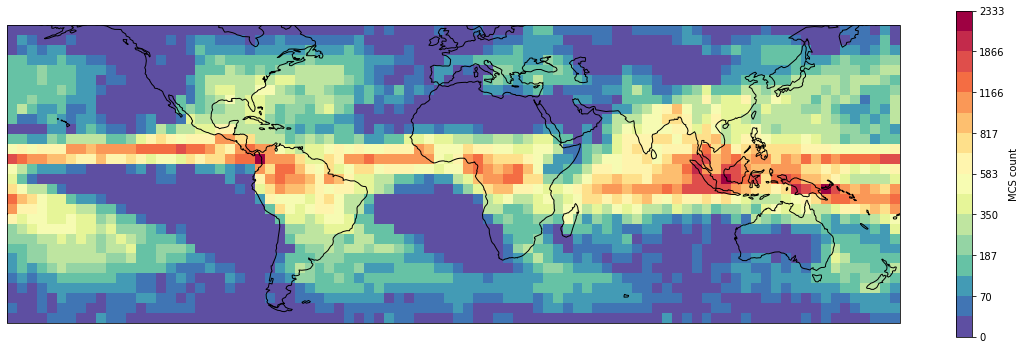

In [5]:
plot_heatmap(dstracks)

In [6]:
# Do regional filtering here to get just South Asia, then use the above function to plot the results.